In [ ]:
import os
#os.environ['http_proxy'] = "http://127.0.0.1:20171" 
#os.environ['https_proxy'] = "https://127.0.0.1:20171" 
os.environ['http_proxy'] = "" 
os.environ['https_proxy'] = "" 

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # just use one GPU on big machine
import torch
import sys
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
assert torch.cuda.device_count() == 1
print('GPU Device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
!nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print ('used memory', torch.cuda.memory_allocated(0))

In [ ]:
!nvidia-smi

In [ ]:
%env WANDB_API_KEY=4e1502d9adcd356733796069ff0ef1eab9ef169b
import wandb
wandb.login()

In [ ]:
"""
Copyright (c) Meta Platforms, Inc. and affiliates.

This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""
import sys
from pathlib import Path
import logging
import re
import argparse
import re
from functools import partial
import torch
from torch.utils.data import ConcatDataset
from tqdm import tqdm
from nougat import NougatModel
from nougat.utils.dataset import LazyDataset
from nougat.utils.checkpoint import get_checkpoint
from nougat.postprocessing import markdown_compatible
import fitz

logging.basicConfig(level=logging.INFO)

In [ ]:
if torch.cuda.is_available():
    BATCH_SIZE = int(
        torch.cuda.get_device_properties(0).total_memory / 1024 / 1024 / 1000 * 0.3
    )
    if BATCH_SIZE == 0:
        logging.warning("GPU VRAM is too small. Computing on CPU.")
else:
    # don't know what a good value is here. Would not recommend to run on CPU
    BATCH_SIZE = 1
    logging.warning("No GPU found. Conversion on CPU is very slow.")

In [ ]:
import os
from PIL import Image, ImageOps

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--batchsize",
        "-b",
        type=int,
        default=BATCH_SIZE,
        help="Batch size to use.",
    )
    parser.add_argument(
        "--checkpoint",
        "-c",
        type=Path,
        default=None,
        help="Path to checkpoint directory.",
    )
    parser.add_argument("--out", "-o", type=Path, help="Output directory.")
    parser.add_argument(
        "--recompute",
        action="store_true",
        help="Recompute already computed PDF, discarding previous predictions.",
    )
    parser.add_argument(
        "--markdown",
        action="store_true",
        help="Add postprocessing step for markdown compatibility.",
    )
    parser.add_argument("pdf", nargs="+", type=Path, help="PDF(s) to process.")
    args = parser.parse_args()
    if args.checkpoint is None or not args.checkpoint.exists():
        args.checkpoint = get_checkpoint(args.checkpoint)
    if args.out is None:
        logging.warning("No output directory. Output will be printed to console.")
    else:
        if not args.out.exists():
            logging.info("Output directory does not exist. Creating output directory.")
            args.out.mkdir(parents=True)
        if not args.out.is_dir():
            logging.error("Output has to be directory.")
            sys.exit(1)
    if len(args.pdf) == 1 and not args.pdf[0].suffix == ".pdf":
        # input is a list of pdfs
        try:
            args.pdf = [
                Path(l) for l in open(args.pdf[0]).read().split("\n") if len(l) > 0
            ]
        except:
            pass
    return args


def predict(args):
    #args = get_args()
    model = NougatModel.from_pretrained(args.checkpoint).to(torch.bfloat16)
    print(model)
    if args.batchsize > 0:
        if torch.cuda.is_available():
            model.to("cuda")
    else:
        # set batch size to 1. Need to check if there are benefits for CPU conversion for >1
        args.batchsize = 1
    model.eval()
    datasets = []
    for pdf in args.pdf:
        if not pdf.exists():
        #if not os.path.exists(pdf):
            continue
        if args.out:
            out_path = args.out / pdf.with_suffix(".mmd").name
            print(out_path)
            if out_path.exists() and not args.recompute:
                logging.info(
                    f"Skipping {pdf.name}, already computed. Run with --recompute to convert again."
                )
                continue
        try:
            dataset = LazyDataset(
                pdf, partial(model.encoder.prepare_input, random_padding=False)
            )
        except fitz.fitz.FileDataError:
            logging.info(f"Could not load file {str(pdf)}.")
            continue
        datasets.append(dataset)
    if len(datasets) == 0:
        return
    dataloader = torch.utils.data.DataLoader(
        ConcatDataset(datasets),
        batch_size=args.batchsize,
        shuffle=False,
        collate_fn=LazyDataset.ignore_none_collate,
    )

    predictions = []
    file_index = 0
    page_num = 0
    for i, (sample, is_last_page) in enumerate(tqdm(dataloader)):
        model_output = model.inference(image_tensors=sample)
        # check if model output is faulty
        for j, output in enumerate(model_output["predictions"]):
            if page_num == 0:
                logging.info(
                    "Processing file %s with %i pages"
                    % (datasets[file_index].name, datasets[file_index].size)
                )
            page_num += 1
            if output.strip() == "[MISSING_PAGE_POST]":
                # uncaught repetitions -- most likely empty page
                predictions.append(f"\n\n[MISSING_PAGE_EMPTY:{page_num}]\n\n")
            elif model_output["repeats"][j] is not None:
                if model_output["repeats"][j] > 0:
                    # If we end up here, it means the output is most likely not complete and was truncated.
                    logging.warning(f"Skipping page {page_num} due to repetitions.")
                    predictions.append(f"\n\n[MISSING_PAGE_FAIL:{page_num}]\n\n")
                else:
                    # If we end up here, it means the document page is too different from the training domain.
                    # This can happen e.g. for cover pages.
                    predictions.append(
                        f"\n\n[MISSING_PAGE_EMPTY:{i*args.batchsize+j+1}]\n\n"
                    )
            else:
                if args.markdown:
                    output = markdown_compatible(output)
                predictions.append(output)
            if is_last_page[j]:
                out = "".join(predictions).strip()
                out = re.sub(r"\n{3,}", "\n\n", out).strip()
                if args.out:
                    out_path = args.out / Path(is_last_page[j]).with_suffix(".mmd").name
                    out_path.parent.mkdir(parents=True, exist_ok=True)
                    out_path.write_text(out, encoding="utf-8")
                else:
                    print(out, "\n\n")
                predictions = []
                page_num = 0
                file_index += 1

In [ ]:
def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding, fill = 'white')

def predict_from_image(checkpoint, images, markdown, outpath, batchsize=1):
    
    model = NougatModel.from_pretrained(args.checkpoint).to(torch.float32)
    if batchsize > 0:
        if torch.cuda.is_available():
            model.to("cuda")
    else:
        #set batch size to 1. Need to check if there are benefits for CPU conversion for >1
        batchsize = 1
    model.eval()
    for image in images:
        sample = Image.open(image).convert('RGB')
        prepare = model.encoder.prepare_input
        im_new = resize_with_padding(sample, (672,896))     
        img_tensor = prepare(im_new,random_padding=False)
        img_tensor = img_tensor.unsqueeze(0) 
        model_output = model.inference(image_tensors=img_tensor)
        predictions = []
        for j, output in enumerate(model_output["predictions"]):
            predictions.append(output)   
            # check if model output is faulty
            if markdown:
                output = markdown_compatible(output)

    out = "".join(predictions).strip()
    out = re.sub(r"\n{3,}", "\n\n", out).strip()
    if outpath:
        out_file = outpath / Path(images[0].stem).with_suffix(".mmd").name
        out_file.parent.mkdir(parents=True, exist_ok=True)
        if out_file.exists():
            os.remove(out_file)
        with open(out_file,mode="w",encoding="utf-8") as f:
             f.write(out)
    else:
        print(out, "\n\n")
        
    return model_output

In [ ]:
def predict_normal(args):
    #args = get_args()
    model = NougatModel.from_pretrained(args.checkpoint).to(torch.float16)
    #print(model)
    if args.batchsize > 0:
        if torch.cuda.is_available():
            model.to("cuda")
    else:
        # set batch size to 1. Need to check if there are benefits for CPU conversion for >1
        args.batchsize = 1
    model.eval()
    datasets = []
    output = ""   
    for pdf in args.pdf:
        if not pdf.exists():
        #if not os.path.exists(pdf):
            continue
        if args.out:
            out_path = args.out / pdf.with_suffix(".mmd").name
            print(out_path)
            if out_path.exists() and not args.recompute:
                logging.info(
                    f"Skipping {pdf.name}, already computed. Run with --recompute to convert again."
                )
                continue
        try:
            dataset = LazyDataset(
                pdf, partial(model.encoder.prepare_input, random_padding=False)
            )
        except fitz.fitz.FileDataError:
            logging.info(f"Could not load file {str(pdf)}.")
            continue
        datasets.append(dataset)
    if len(datasets) == 0:
        return
    dataloader = torch.utils.data.DataLoader(
        ConcatDataset(datasets),
        batch_size=args.batchsize,
        shuffle=False,
        collate_fn=LazyDataset.ignore_none_collate,
    )

    predictions = []
    file_index = 0
    page_num = 0
    for i, (sample, is_last_page) in enumerate(tqdm(dataloader)):
        model_output = model.inference(image_tensors=sample)
        #print(sample[0])
        #print(sample.size())
        # check if model output is faulty
        for j, output in enumerate(model_output["predictions"]):
            if page_num == 0:
                logging.info(
                    "Processing file %s with %i pages"
                    % (datasets[file_index].name, datasets[file_index].size)
                )
            page_num += 1
            if output.strip() == "[MISSING_PAGE_POST]":
                # uncaught repetitions -- most likely empty page
                predictions.append(f"\n\n[MISSING_PAGE_EMPTY:{page_num}]\n\n")
            elif model_output["repeats"][j] is not None:
                if model_output["repeats"][j] > 0:
                    # If we end up here, it means the output is most likely not complete and was truncated.
                    logging.warning(f"Skipping page {page_num} due to repetitions.")
                    predictions.append(f"\n\n[MISSING_PAGE_FAIL:{page_num}]\n\n")
                else:
                    # If we end up here, it means the document page is too different from the training domain.
                    # This can happen e.g. for cover pages.
                    predictions.append(
                        f"\n\n[MISSING_PAGE_EMPTY:{i*args.batchsize+j+1}]\n\n"
                    )
            else:
                if args.markdown:
                    output = markdown_compatible(output)
                predictions.append(output)
                print(predictions)
            if is_last_page[j]:
                out = "".join(predictions).strip()
                out = re.sub(r"\n{3,}", "\n\n", out).strip()
                if args.out:
                    out_path = args.out / Path(is_last_page[j]).with_suffix(".mmd").name
                    out_path.parent.mkdir(parents=True, exist_ok=True)
                    if out_path.exists():
                        os.remove(out_path)
                    with open(out_path,mode="w",encoding="utf-8") as f:
                         f.write(out)
                    #out_path.write_text(out, encoding="utf-8")
                else:
                    print(out, "\n\n")
                predictions = []
                page_num = 0
                file_index += 1   
    return model_output

In [ ]:
import pathlib
class base_args:
    #config 1
    pdf = pathlib.Path("./input/test.pdf")
    image = pathlib.Path("./input/")
    out = pathlib.Path("./output")
    checkpoint = pathlib.Path("/workspace/nougat-latex/config2/")
    config = pathlib.Path("/workspace/nougat-latex/config2/config.json")  
    #config 2
    #pdf = pathlib.Path("./input/test.pdf"),
    #out = pathlib.Path("../../../data1/replicate-nougat/output"),
    #checkpoint = pathlib.Path("../../../data1/replicate-nougat/model/base/"),
    #config = pathlib.Path("../../../data1/replicate-nougat/nougat/config.json"),
    
    #config 3
    #out = pathlib.Path("../../../data1/nielsr-nougat/output/"),
    #checkpoint = "../../../data1/nielsr-nougat/",
    #config = "../../../data1/nielsr-nougat/config.json",
    recompute = False
    markdown = True
    batchsize = BATCH_SIZE

base_args = base_args()
args = base_args

In [ ]:
import requests
from urllib.parse import urlparse, unquote

url_list = ["https://cdn.mathpix.com/snip/images/Hm62Ib-dDZOseYuVNN8k34IhBY18KglOrM7qETOqXZI.original.fullsize.png", 
        "https://cdn.mathpix.com/snip/images/lSL07DYTL1bdjzL2mpNyVg17JmqKwgugMLyGuxkLgLg.original.fullsize.png"]

query_parameters = {"downloadformat": "image"}
for url in url_list:
    url_parsed = urlparse(url)
    file_path = Path(url_parsed.path)
    new_path = Path("./input")
    new_file = os.path.join(new_path, os.path.basename(file_path))
    response = requests.get(url, stream=True)
    if response.ok:
        with open(new_file, mode="wb") as file:
            for data in tqdm(response.iter_content()):
                file.write(data)

## fitz convert to pdf

In [ ]:
import fitz

args.image = pathlib.Path("./input")
imglist= [f for f in args.image.glob("*.png") if f.is_file()]
args.images = imglist


def convdert_imag2pdf(imglist):
    doc = fitz.open()                           # new PDF
    for img in imglist:
        OUTPUT_FILENAME = args.image / Path(os.path.basename(img)).with_suffix(".pdf").name
        if OUTPUT_FILENAME.exists():
            os.remove(OUTPUT_FILENAME)
        imgdoc=fitz.open(img)               # open image as a document
        pdfbytes=imgdoc.convert_to_pdf()    # make a 1-page PDF of it
        imgpdf=fitz.open("pdf", pdfbytes)
        doc.insert_pdf(imgpdf)              # insert the image PDF
        doc.save(OUTPUT_FILENAME)

convdert_imag2pdf(imglist)

In [ ]:
for img in imglist:
    print(os.path.basename(img))

## PIL image convert to pdf

In [ ]:
from PIL import Image
import torchvision.transforms as transforms 
import img2pdf

#sample = Image.open(new_file)
#im_1 = sample.convert('RGB')
#pdf_1 = args.out / Path(os.path.basename(new_file)).with_suffix(".pdf").name
#im_1.save(pdf_1)

sample = Image.open(new_file)
pdf_1 = args.out / Path(os.path.basename(new_file)).with_suffix(".pdf").name
pdf_bytes = img2pdf.convert(sample.filename)
# opening or creating pdf file
file = open(pdf_1, "wb")
# writing pdf files with chunks
file.write(pdf_bytes)
# closing image file
sample.close()
# closing pdf file
file.close()

## reportlba conver to pdf

In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.lib.utils import ImageReader
from reportlab.pdfgen import canvas

def convert_png_to_pdf(png_folder, output_pdf_path):
    c = canvas.Canvas(output_pdf_path, pagesize=letter)

    # Get a list of all PNG files in the folder
    png_files = [f for f in os.listdir(png_folder) if f.endswith('.png')]

    for png_file in png_files:
        png_path = os.path.join(png_folder, png_file)

        # Open the PNG image using Pillow
        image = ImageReader(png_path)

        # Add the image to the PDF canvas
        c.setPageSize((image.getSize()[0], image.getSize()[1]))
        c.drawImage(image, 0, 0)

        # Create a new page
        c.showPage()

    # Save the resulting PDF file
    c.save()

    print(f'PDF file created successfully: {output_pdf_path}')
os.remove(pdf_1)
convert_png_to_pdf("./input/",str(pdf_1))

In [ ]:
import numpy as np
from PIL import Image

sample = Image.open("./input/IMG_20231130_210017.png")
display(sample)
# Define a transform to convert PIL  
# image to a Torch tensor 

In [ ]:
import numpy as np
import pathlib  
from nougat.dataset.rasterize import rasterize_paper
from nougat.utils.dataset import LazyDataset,ImageDataset

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
#cuda0 = torch.cuda.set_device(0)
#assert torch.cuda.device_count() == 1
print('GPU Device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

checkpoint = pathlib.Path("/workspace/nougat-latex/config1/")
model = NougatModel.from_pretrained(checkpoint).to(torch.float32)


In [ ]:
convert = 0
sample = Image.open("./input/Hm62Ib-dDZOseYuVNN8k34IhBY18KglOrM7qETOqXZI.original.fullsize.png")

prepare = model.encoder.prepare_input
im_new = resize_with_padding(sample, (672,896))     
img_tensor = prepare(im_new,random_padding=False)
img_tensor = img_tensor.unsqueeze(0) 
model_output = model.inference(image_tensors=img_tensor)

# predict via image

In [ ]:
import glob
args.image = pathlib.Path("./input/")
fileList= [f for f in args.image.glob("*.png") if f.is_file()]
args.images = fileList
args.recompute = True
args.out = pathlib.Path("./output/")
args.checkpoint = pathlib.Path("/home/ubuntu/notebook/nougat-latex/config2/")
args.config = pathlib.Path("/home/ubuntu/notebook/nougat-latex/config2/config.json")  

args.checkpoint = pathlib.Path("/workspace/nougat-latex/config2.1")
args.config = pathlib.Path("/workspace/nougat-latex/config2.1/config.json")  

#predict_image(args,model)

#model = NougatModel.from_pretrained(args.checkpoint).to(torch.bfloat16)
#sample = Image.open("/kaggle/working/Hm62Ib-dDZOseYuVNN8k34IhBY18KglOrM7qETOqXZI.original.fullsize.png")
#prepare = model.encoder.prepare_input
#im_new = resize_with_padding(sample, (672,896))     
#img_tensor = prepare(im_new,random_padding=False)
#img_tensor = img_tensor.unsqueeze(0) 

model_output = predict_from_image(args.checkpoint,args.images, args.markdown, args.out, args.batchsize)

In [ ]:
print(model_output['predictions'])

In [ ]:
args.images

In [ ]:
#args.pdf = [pathlib.Path("./input/Hm62Ib-dDZOseYuVNN8k34IhBY18KglOrM7qETOqXZI.original.fullsize.pdf"),
#            pathlib.Path("./input/lSL07DYTL1bdjzL2mpNyVg17JmqKwgugMLyGuxkLgLg.original.fullsize.pdf")]
#args.pdf = [pathlib.Path("./input/lSL07DYTL1bdjzL2mpNyVg17JmqKwgugMLyGuxkLgLg.original.fullsize.pdf"),]
args.pdf = [pathlib.Path("./input/test.pdf"),]
args.recompute = True
args.checkpoint = pathlib.Path("/workspace/nougat-latex/config2/")
args.config = pathlib.Path("/workspace/nougat-latex/config2/config.json")  

#args.checkpoint = pathlib.Path("/home/ubuntu/notebook/deeplearning/labs/nougat/result/nougat/1.0/")
#args.config = pathlib.Path("/home/ubuntu/notebook/deeplearning/labs/nougat/result/nougat/1.0/config.json")  

predict_normal(args)

In [ ]:
args.checkpoint

### Validate the LazyDataset --> ImageDataset --> rasterize_paper 

In [ ]:
pdf_list_fn = partial(rasterize_paper, pathlib.Path("./input/test.pdf"), pages=None)
prepare = partial(model.encoder.prepare_input, random_padding=False)

#pdf_list = pdf_list_fn()
dataset_image = ImageDataset(pdf_list_fn, prepare)

In [ ]:
from torch.utils.data import ConcatDataset
try:
    dataset = LazyDataset(
        pathlib.Path("./input/test.pdf"), partial(model.encoder.prepare_input, random_padding=False)
    )
except fitz.fitz.FileDataError:
    logging.info(f"Could not load file {str(pdf)}.")

datasets = []
datasets.append(dataset)

dataloader = torch.utils.data.DataLoader(
    ConcatDataset(datasets),
    batch_size=4,
    shuffle=False,
    collate_fn=LazyDataset.ignore_none_collate,
)

In [ ]:
dset = iter(dataloader)
batch = next(dset)
sample, is_last_page = batch

In [ ]:
batch = next(dset)
seq, im = batch

In [ ]:
sample

In [ ]:
model_output = model.inference(image_tensors=sample)

In [ ]:
model_output

In [ ]:
import matplotlib.pyplot as plt
img = sample[0][0]
#img = img.reshape(img.shape[1],img.shape[2],1)
plt.imshow(img)
print(im)

In [ ]:
list = dataset_image.img_list()

In [ ]:
list

In [ ]:
from PIL import Image 
im = Image.open(list[1])
display(im)

# using latex-ocr data as input to check the inference working or not 

## contruct the data as latex-ocr have done

In [ ]:
import pathlib
import yaml
from pix2tex.utils import parse_args
from munch import Munch

import pathlib
class base_args:
    #config 1
    debug = False
    resume = False
    no_cuda = False
    config = pathlib.Path("colab.yaml")

parsed_args = base_args()

with open(pathlib.Path("colab.yaml"), 'r') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
ocr_args = parse_args(Munch(params), **vars(parsed_args))

In [ ]:
from pix2tex.dataset.dataset import Im2LatexDataset
data = "../deeplearning/labs/LaTeX-OCR/dataset/data/train.pkl"
valdata = "../deeplearning/labs/LaTeX-OCR/dataset/data/val.pkl"
dataloader = Im2LatexDataset().load(data)
dataloader.update(**ocr_args, test=False)
valdataloader = Im2LatexDataset().load(valdata)

In [ ]:
dset = iter(dataloader)
batch = next(dset)
seq, im = batch

In [ ]:
import matplotlib.pyplot as plt
j = 0
img = seq['input_ids'][j:j+2]
mask = seq['attention_mask'][j:j+2].bool()
plt.figure(figsize = (20,5))
plt.imshow(img)
print(img.size())
print(mask)

In [ ]:
j=0
img = im[j:j+1][0]
print(img)
print(img.shape)

img2 = np.zeros( ( np.array(img).shape[1], np.array(img).shape[2], 3 ) )
img2[:,:,0] = img # same value in each channel
img2[:,:,1] = img
img2[:,:,2] = img

img = img.reshape(img.shape[1],img.shape[2],1)
plt.imshow(img)
plt.imshow(img2)
print(img.size())

## proceed the latex-ocr image from meneory and invert 

In [ ]:
#color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB) 
from matplotlib import cm
import PIL.ImageOps
#pil_image = Image.fromarray(np.uint8(img2))
PIL_image = Image.fromarray(img2.astype('uint8'), 'RGB')
display(pil_image)
pil_image = PIL.ImageOps.invert(img) 
display(pil_image)
#pil_image.show() 

In [ ]:
import torchvision.transforms as T
transform = T.ToPILImage()
img = transform(img2)
display(img)

In [ ]:
import torchvision.transforms as transforms 
  
# Define a transform to convert PIL  
# image to a Torch tensor 
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 
  
# transform = transforms.PILToTensor() 
# Convert the PIL image to Torch tensor 
img_tensor = transform(img) 
x = img_tensor.unsqueeze(0) 

In [ ]:
model_output = model.inference(image_tensors=x)

In [ ]:
output = model_output["predictions"]
output

# OCR Pre-Processing

In [55]:
import cv2
import numpy as np

threshold_value = 150
maxval = 255



image = cv2.imread("/workspace/nougatLatex/uploads/cropped505794461585712511.jpg")
image = cv2.imread("/workspace/nougatLatex/uploads/cropped1780205042622287499.jpg")

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 对灰度图使用Otsu算法
ret1, th1 = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)

# 绘制灰度直方图
plt.subplot(312), plt.hist(gray_image.ravel(), 256)
# 标注Otsu阈值所在直线
plt.axvline(x=ret1, color='red', label='otsu')
plt.legend(loc='upper right')
plt.title("Histogram"), plt.xticks([]), plt.yticks([])
# 绘制二值化图像
plt.subplot(313), plt.imshow(th1, "gray")
plt.title("output image"), plt.xticks([]), plt.yticks([])
plt.show()

_, binarized_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

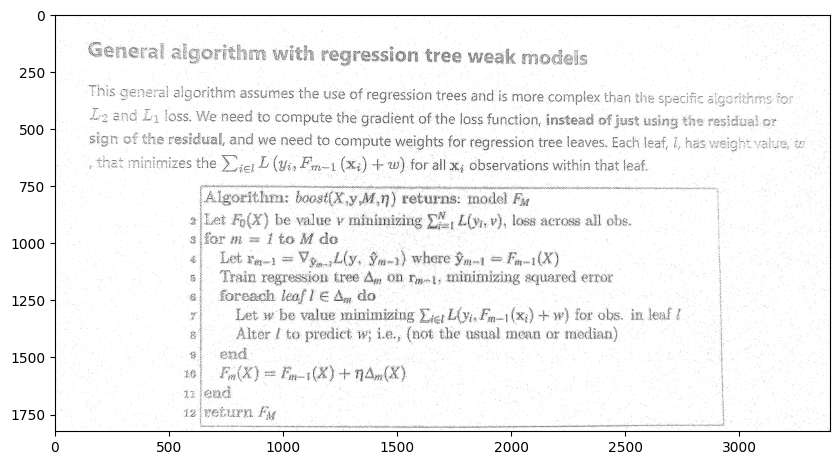

In [8]:
import cv2

img = cv2.imread("/workspace/nougatLatex/uploads/cropped1780205042622287499.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
adaptive_threshold_gaussian = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 6)
plt.figure(figsize = (10,10))
plt.imshow(adaptive_threshold_gaussian, 'gray')

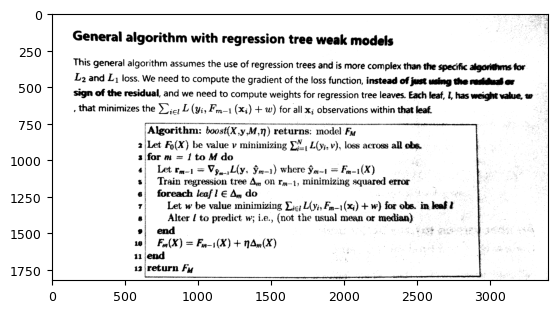

In [58]:
from matplotlib import pyplot as plt
plt.imshow(binarized_image, "gray")

True

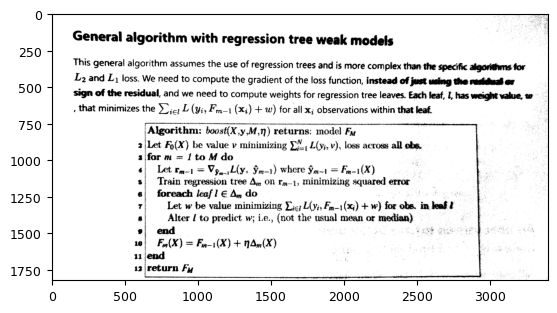

In [59]:
backtorgb = cv2.cvtColor(binarized_image,cv2.COLOR_GRAY2RGB)
plt.imshow(backtorgb)
cv2.imwrite("./output/binarized_image.png", binarized_image)

In [60]:
backtorgb.shape

(1824, 3397, 3)

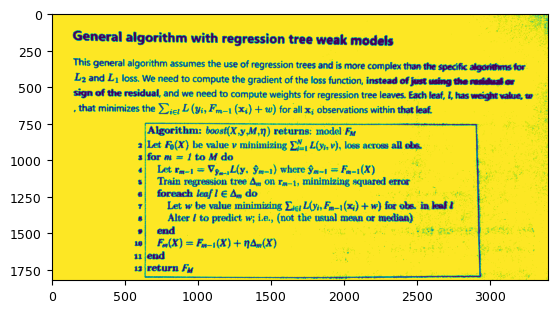

In [39]:
from matplotlib import pyplot as plt
plt.imshow(binarized_image)

In [10]:
import math
def integral(img):
    '''
    计算图像的积分和平方积分
    :param img:Mat--- 输入待处理图像
    :return:integral_sum, integral_sqrt_sum：Mat--- 积分图和平方积分图
    '''
    integral_sum=np.zeros((img.shape[0],img.shape[1]),dtype=np.int32)
    integral_sqrt_sum=np.zeros((img.shape[0],img.shape[1]),dtype=np.int32)
 
    rows,cols=img.shape
    for r in range(rows):
        sum=0
        sqrt_sum=0
        for c in range(cols):
            sum+=img[r][c]
            sqrt_sum+=math.sqrt(img[r][c])
 
            if r==0:
                integral_sum[r][c]=sum
                integral_sqrt_sum[r][c]=sqrt_sum
            else:
                integral_sum[r][c]=sum+integral_sum[r-1][c]
                integral_sqrt_sum[r][c]=sqrt_sum+integral_sqrt_sum[r-1][c]
 
    return integral_sum, integral_sqrt_sum
 
def sauvola(img,k=0.1,kernerl=(31,31)):
    '''
    sauvola阈值法。
    根据当前像素点邻域内的灰度均值与标准方差来动态计算该像素点的阈值
    :param img:Mat--- 输入待处理图像
    :param k:float---修正参数,一般0<k<1
    :param kernerl:set---窗口大小
    :return:img:Mat---阈值处理后的图像
    '''
    if kernerl[0]%2!=1 or kernerl[1]%2!=1:
        raise ValueError('kernerl元组中的值必须为奇数, 请检查kernerl[0] or kernerl[1]是否为奇数!!!')
 
    # 计算积分图和积分平方和图
    integral_sum,integral_sqrt_sum=integral(img)
    # integral_sum, integral_sqrt_sum = cv2.integral2(img)
    # integral_sum=integral_sum[1:integral_sum.shape[0],1:integral_sum.shape[1]]
    # integral_sqrt_sum=integral_sqrt_sum[1:integral_sqrt_sum.shape[0],1:integral_sqrt_sum.shape[1]]
 
    #创建图像
    rows,cols=img.shape
    diff=np.zeros((rows,cols),np.float32)
    sqrt_diff=np.zeros((rows,cols),np.float32)
    mean=np.zeros((rows,cols),np.float32)
    threshold=np.zeros((rows,cols),np.float32)
    std=np.zeros((rows,cols),np.float32)
 
    whalf=kernerl[0]>>1#计算领域类半径的一半
 
    for row in range(rows):
        #print('第{}行处理中...'.format(row))
        for col in range(cols):
            xmin=max(0,row-whalf)
            ymin=max(0,col-whalf)
            xmax=min(rows-1,row+whalf)
            ymax=min(cols-1,col+whalf)
 
            area=(xmax-xmin+1)*(ymax-ymin+1)
            if area<=0:
                sys.exit(1)
 
            if xmin==0 and ymin==0:
                diff[row,col]=integral_sum[xmax,ymax]
                sqrt_diff[row,col]=integral_sqrt_sum[xmax,ymax]
            elif xmin>0 and ymin==0:
                diff[row, col] = integral_sum[xmax, ymax]-integral_sum[xmin-1,ymax]
                sqrt_diff[row, col] = integral_sqrt_sum[xmax, ymax]-integral_sqrt_sum[xmin-1, ymax]
            elif xmin==0 and ymin>0:
                diff[row, col] = integral_sum[xmax, ymax] - integral_sum[xmax, ymax-1]
                sqrt_diff[row, col] = integral_sqrt_sum[xmax, ymax] - integral_sqrt_sum[xmax, ymax-1]
            else:
                diagsum=integral_sum[xmax, ymax]+integral_sum[xmin-1, ymin-1]
                idiagsum=integral_sum[xmax, ymin-1]+integral_sum[xmin-1, ymax]
                diff[row,col]=diagsum-idiagsum
 
                sqdiagsum=integral_sqrt_sum[xmax, ymax]+integral_sqrt_sum[xmin-1, ymin-1]
                sqidiagsum=integral_sqrt_sum[xmax, ymin-1]+integral_sqrt_sum[xmin-1, ymax]
                sqrt_diff[row,col]=sqdiagsum-sqidiagsum
 
            mean[row,col]=diff[row, col]/area
            std[row,col]=math.sqrt((sqrt_diff[row,col]-math.sqrt(diff[row,col])/area)/(area-1))
            threshold[row,col]=mean[row,col]*(1+k*((std[row,col]/128)-1))
 
            if img[row,col]<threshold[row,col]:
                img[row,col]=0
            else:
                img[row,col]=255
 
    return img

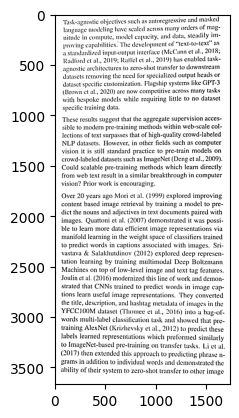

In [12]:
from matplotlib import pyplot as plt

image = cv2.imread("/workspace/nougatLatex/uploads/cropped1780205042622287499.jpg")
image = cv2.imread("/workspace/nougatLatex/uploads/cropped7991135679009883370.jpg")

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sauvola_img = sauvola(gray_image)
plt.imshow(sauvola_img)
cv2.imwrite("sauvola.png", sauvola_img)
backtorgb = cv2.cvtColor(sauvola_img,cv2.COLOR_GRAY2RGB)
plt.imshow(backtorgb)

In [40]:
test_img.shape

(1824, 3397)

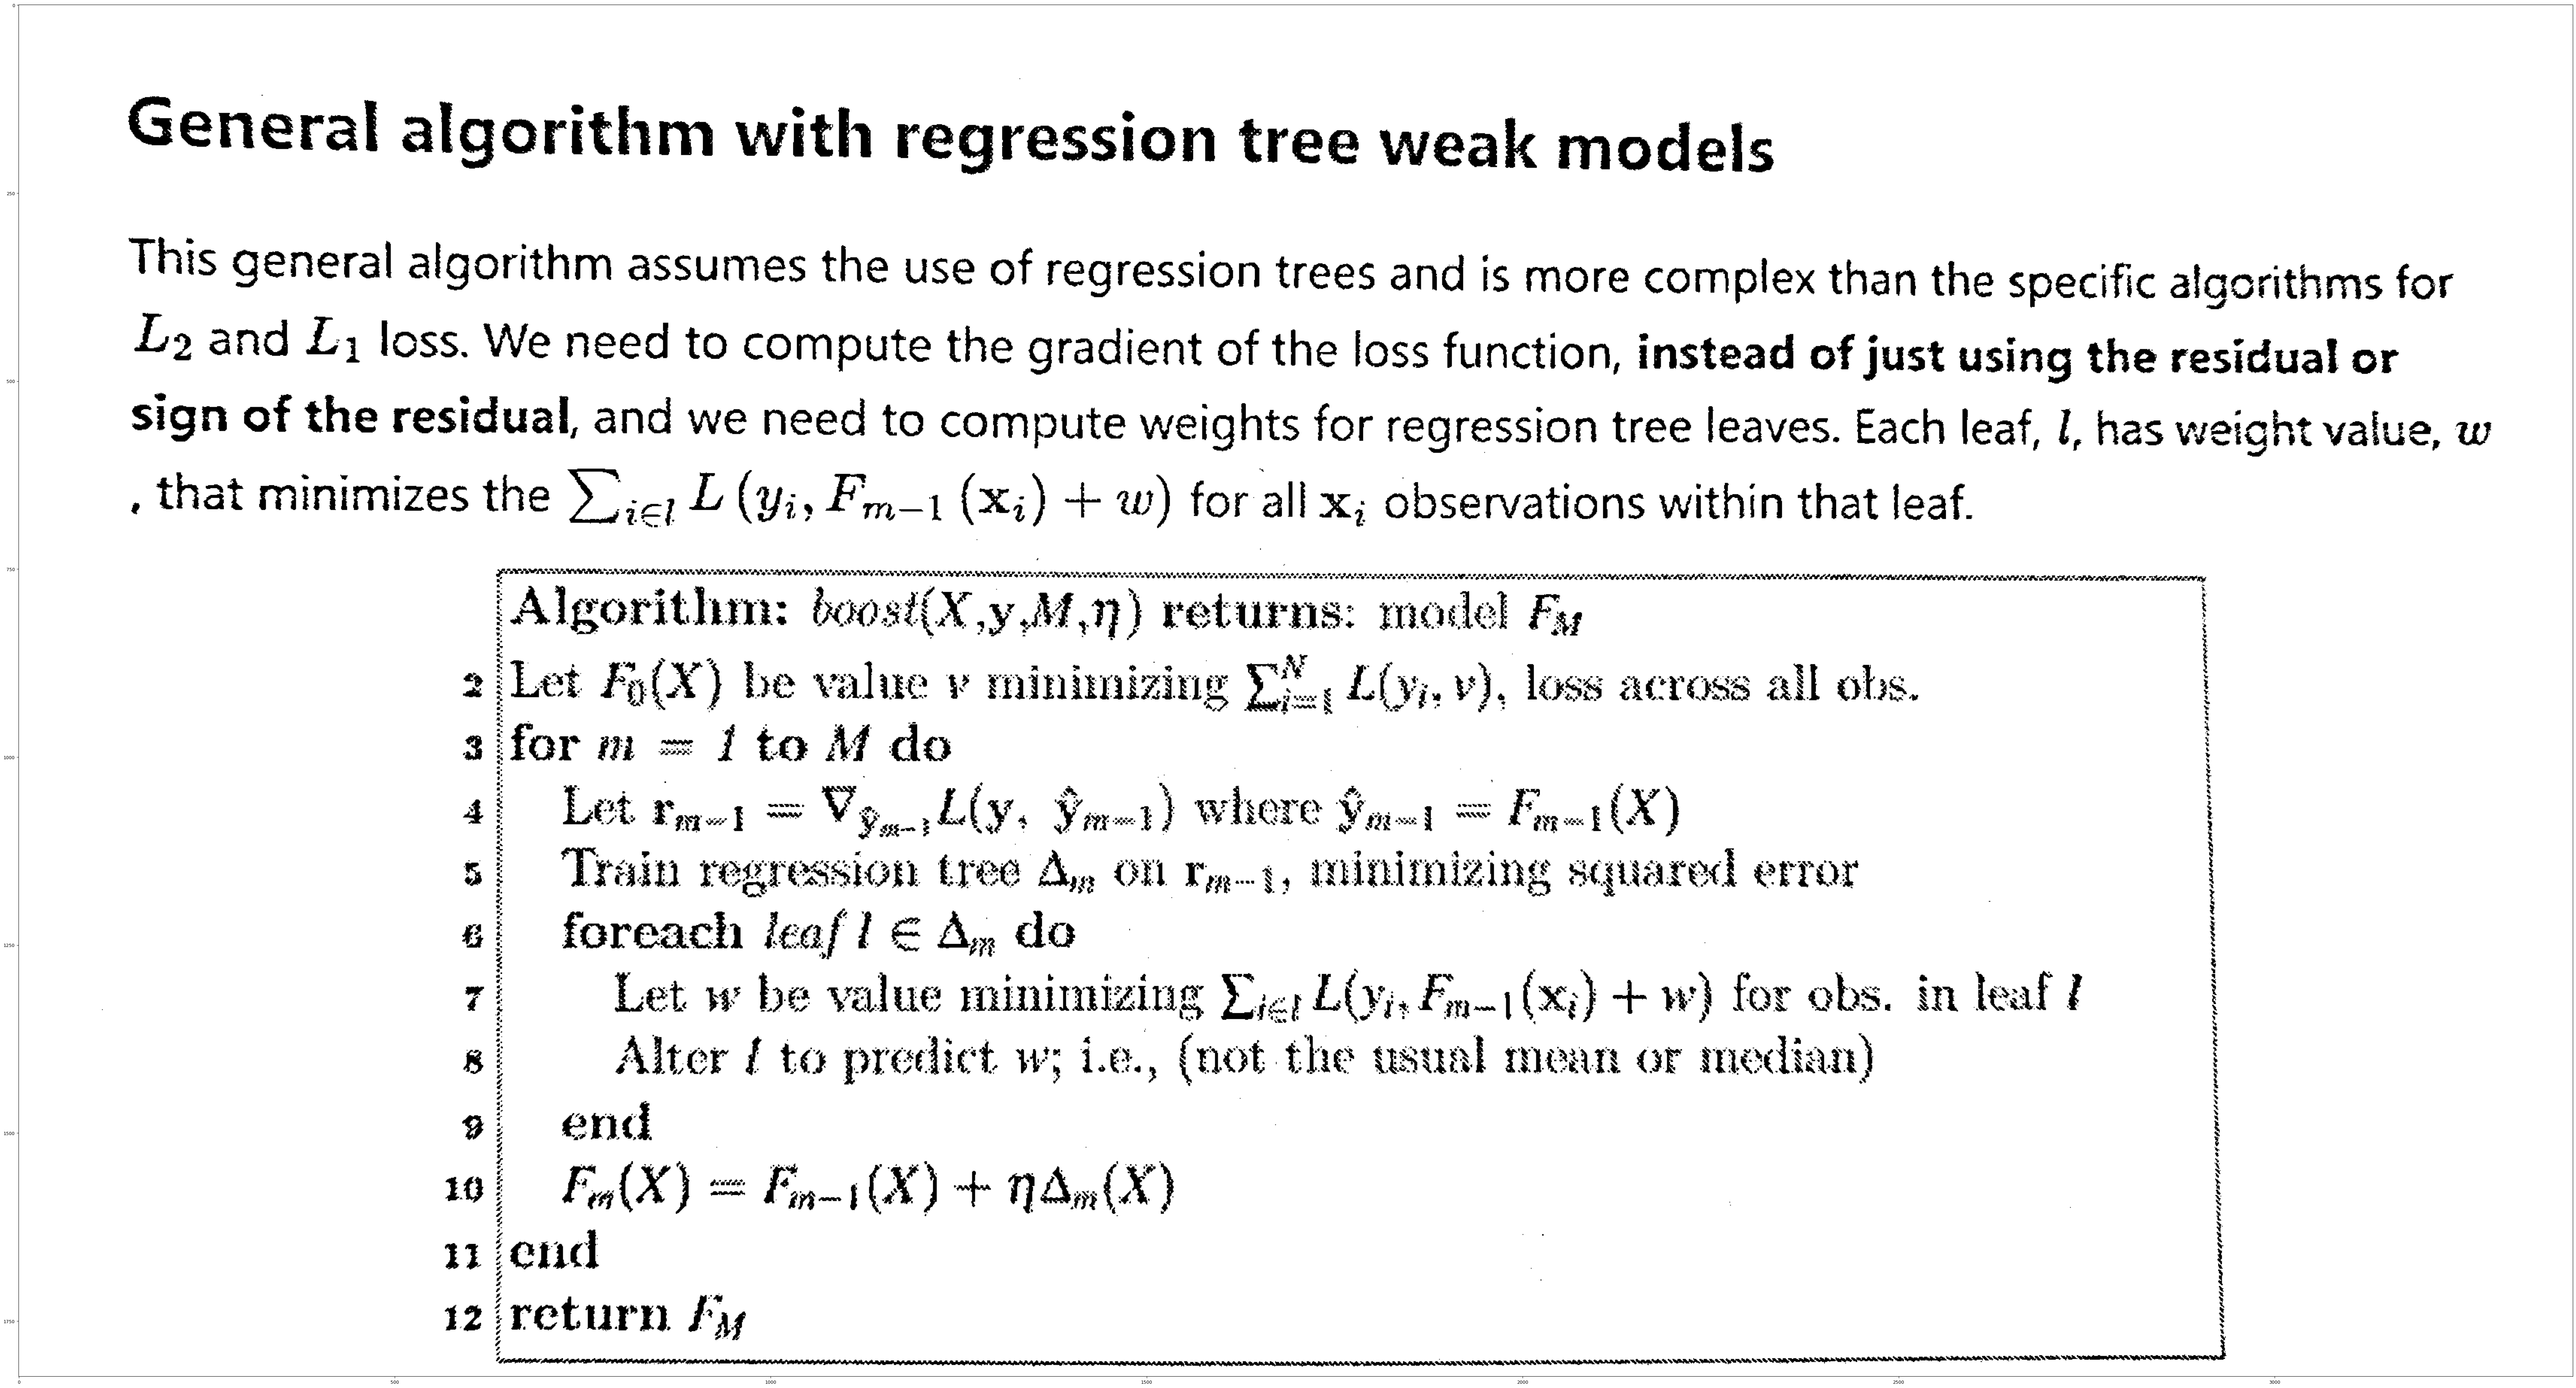

In [53]:
from matplotlib import pyplot as plt
plt.figure(figsize = (100,50))
plt.imshow(test_img, "gray")

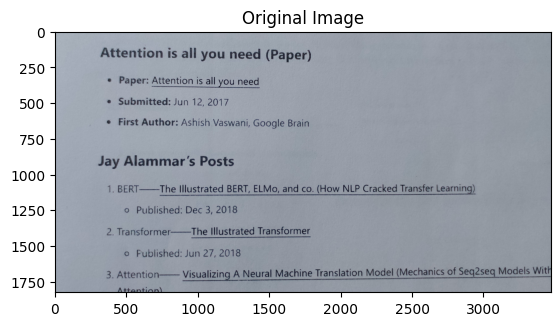

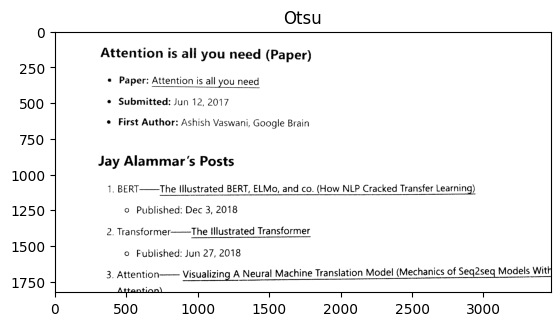

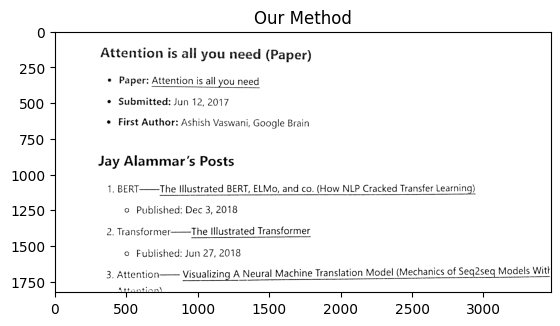

In [1]:
#libraries
import numpy as np
from numpy import linalg
import cv2
from math import sqrt
from math import atan
from math import pow
import matplotlib.pyplot as plt
import glob
from PIL import Image

#reading the image
a = cv2.imread("/workspace/nougatLatex/uploads/cropped505794461585712511.jpg")

#showing the original image
plt.title("Original Image")
plt.imshow(a)
plt.show()

#making 3 grayscale images 
b = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
c = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
d = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

#k-value range [0.1-0.5] can be changed depending on image
k=0.2

#r-value can be changed depending on image
r=128

#neighbouring window size can be changed depending on image
window=35

#otsu thresholding
ret2,th= cv2.threshold(b,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#showing otsu result
plt.title("Otsu")
plt.imshow(th,cmap='gray')
plt.show()


h,w=b.shape

th=0
value=[]
threshold=[]
m=0
var=0
std=0
b,c=cv2.integral2(b)

h,w=c.shape

#Sauvola Method using integrl images
for i in range(1, w , 1):
    for j in range(1, h , 1):
        if(j>(h-int(window/2)) and i>(w-int(window/2))):
            m = (b[j, i] + b[j - int(window/2), i - int(window/2)] - b[
                j , i - int(window/2)] - b[j - int(window/2), i]) / (window * window)
            s = (c[j, i] + c[j - int(window/2), i - int(window/2)] - c[
                j, i - int(window/2)] - c[j - int(window/2), i]) / (window * window)
        elif (i > (w - int(window/2)) and j < (h - int(window/2))):
            m = (b[j + int(window/2), i] + b[j - int(window/2), i - int(window/2)] - b[
                j + int(window/2), i - int(window/2)] - b[j - int(window/2), i]) / (window * window)
            s = (c[j + int(window/2), i] + c[j - int(window/2), i - int(window/2)] - c[
                j + int(window/2), i - int(window/2)] - c[j - int(window/2), i]) / (window * window)
        elif(j>(h-int(window/2)) and i<(w-int(window/2))):
            m = ( b[j,i+int(window/2)]+b[j-int(window/2),i-int(window/2)]-b[j,i-int(window/2)]-b[j-int(window/2),i+int(window/2)])/(window*window)
            s = (  c[j,i+int(window/2)]+c[j-int(window/2),i-int(window/2)]-c[j,i-int(window/2)]-c[j-int(window/2),i+int(window/2)])/(window*window)
        elif(j<(h-int(window/2) ) and i<(w-int(window/2))):
            m=(b[j+int(window/2),i+int(window/2)]+b[j-int(window/2),i-int(window/2)]-b[j+int(window/2),i-int(window/2)]-b[j-int(window/2),i+int(window/2)])/(window*window)
            s=(c[j+int(window/2),i+int(window/2)]+c[j-int(window/2),i-int(window/2)]-c[j+int(window/2),i-int(window/2)]-c[j-int(window/2),i+int(window/2)])/(window*window)
        var = ((s)- (pow((m), 2)))/(window*window)
        std = sqrt(abs(var))
        T = m * (1 + (k * ((std / r) - 1)))
        threshold.append(T)

h1,w1=d.shape

#setting pixel values based on computed threshold
for i in range(0, w1, 1):
     for j in range(0, h1, 1):

        if (d[j, i] <= threshold[th]):
             d[j, i] = 0
        else:
             d[j, i] = 255
        th=th+1
        
for i in range(0, int(window/2), 1):
    for j in range(0, h1, 1):
        d[j,i]=255
for i in range(0, w1, 1):
    for j in range(0, int(window/2), 1):
        d[j,i]=255
        
plt.title("Our Method")
plt.imshow(d,cmap='gray')
plt.show()

In [22]:
import cv2
import numpy as np
img = cv2.imread('/workspace/nougatLatex/uploads/cropped505794461585712511.jpg', 0)
# 使用 getStructuringElement 定义结构元素，shape 为结构元素的形状，0:矩形；1:十字交
# 叉形；2:椭圆形；ksize 为结构元素的大小；anchor 为原点的位置，默认值（-1，-1）表示原点
# 为结构元素的中心点
k = cv2.getStructuringElement(shape=1, ksize=(3, 3), anchor=(-1, -1))
# k = np.ones((3,3),np.uint8) 也可以自己定义一个结构元素
# erode 函数实现腐蚀运算，src 为输入图像，kernel 为之前定义的结构元素，iterations 为
# 腐蚀操作次数
erosion = cv2.erode(src=img, kernel=k, iterations=1)
cv2.imwrite("Eroded_Image.png", erosion)
# dilate 函数实现膨胀运算，参数同上
dilation = cv2.dilate(img, k, iterations=1)
cv2.imwrite("Dilated_Image.png", dilation)
# morphologyEx 函数实现开闭运算, src 为输入图像，op 为运算类型，cv2.MORPH_OPEN：开
# 运算；cv2.MORPH_CLOSE：闭运算，kernel 为结构元素
opening = cv2.morphologyEx(src=img, op=cv2.MORPH_OPEN, kernel=k)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=k)
cv2.imwrite("Opening_Image.png", opening)
cv2.imwrite("Closing_Image.png", closing)

True

In [35]:
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.data import page
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

matplotlib.rcParams['font.size'] = 9

imread('/workspace/nougatLatex/uploads/cropped505794461585712511.jpg')
binary_global = image > threshold_otsu(image)

window_size = 25
thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
thresh_sauvola = threshold_sauvola(image, window_size=window_size)

binary_niblack = image > thresh_niblack
binary_sauvola = image > thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()

/tmp/ipykernel_10977/2261441480.py:11: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (1824, 3397, 3) looks like that of an RGB image.
  binary_global = image > threshold_otsu(image)


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 800x700 with 4 Axes>